# Load Kinecal Data ELEC872 Project
### Cameron Bishop | November 16th 2022

In [2]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import LoadKinecalFunctions
from LoadKinecalFunctions import *
importlib.reload(LoadKinecalFunctions)
from const import User, Exercise
import models
from models import *
importlib.reload(models)



<module 'models' from 'c:\\Users\\camb7\\Code Repositories\\KINECAL Balance Assessment\\KINECAL-Balance-Assessment\\models.py'>

In [3]:
user = User.CD
excerciseList = [Exercise.QSECFS, Exercise.QSEOFS, Exercise.STS, Exercise.TS]

QSClosedDf = readKinecalFiles(excerciseList[0], user) 
QSOpenDf = readKinecalFiles(excerciseList[1], user) 
SemiTandemDf = readKinecalFiles(excerciseList[2], user) 
TandemDf = readKinecalFiles(excerciseList[3], user) 


### Seperate X and Y Dataframes

In [4]:
yDf = QSClosedDf.iloc[:, 0:9]
yDf = yDf.drop(columns='movement')

QSClosedXDf = QSClosedDf.iloc[:, 9:-1]
QSOpenXDf = QSOpenDf.iloc[:, 9:-1]
SemiTandemXDf = SemiTandemDf.iloc[:, 9:-1]
TandemXDf = TandemDf.iloc[:, 9:-1]

print(yDf)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
0       10    HA   m    1.85   77.00 22.50                   1   
1      100    NF   f    1.55   82.50 34.30                   1   
2       11    HA   f    1.57   51.50 20.90                   1   
3       12    HA   m    1.64   68.50 25.50                   1   
4       13    HA   m    1.78   85.00 26.80                   1   
..     ...   ...  ..     ...     ...   ...                 ...   
85      84   FHm   f    1.56   60.00 24.70                   0   
86      87   FHs   f    1.60   77.10 30.10                   0   
87       9    HA   m    1.69   75.00 26.30                   1   
88      92    NF   m    1.83   97.00 29.00                   0   
89      96   FHs   m    1.78   81.20 25.60                   0   

   clinically_at_risk  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
85                  0  
86             

### Replace Missing Data With Mean of That Class

In [5]:
QSClosedXDf = replaceMissingValues(QSClosedXDf, yDf)
QSOpenXDf = replaceMissingValues(QSOpenXDf, yDf)
SemiTandemXDf = replaceMissingValues(SemiTandemXDf, yDf)
TandemXDf = replaceMissingValues(TandemXDf, yDf)


[ 2 14 15]
[ 2 17 29 34 71]
[ 2 14 17 31 33 60 66]
[13 14 17 29 31 33 36 37 55 60 66 74 77]


### Perform Sample Normalization

In [6]:
QSClosedXNormDf = datasetNormalization(QSClosedXDf)
QSOpenXNormDf = datasetNormalization(QSOpenXDf)
SemiTandemXNormDf = datasetNormalization(SemiTandemXDf)
TandemXNormDf = datasetNormalization(TandemXDf)

### Combine Excercises Into One Dataset

In [7]:
print(QSClosedXNormDf.shape, QSOpenXNormDf.shape, SemiTandemXNormDf.shape, TandemXNormDf.shape)
combinedXNormDf = pd.concat([QSClosedXNormDf, QSOpenXNormDf, SemiTandemXNormDf, TandemXDf], axis=1)
print(combinedXNormDf.shape)

(90, 16) (90, 16) (90, 16) (90, 16)
(90, 64)


### Seperate Into Training and Testing Sets

In [18]:
xTrain, xTest, yTrain, yTest = train_test_split(combinedXNormDf, yDf, test_size=0.2, random_state=42)

#export to csv
xTrain.to_csv('xTrain.csv', index=False)
xTest.to_csv('xTest.csv', index=False)
yTrain.to_csv('yTrain.csv', index=False)
yTest.to_csv('yTest.csv', index=False)

le = LabelEncoder()

yTest_orig = yTest
yTrain_orig = yTrain

xTest_orig = xTest
xTrain_orig = xTrain

yTest = le.fit_transform(yTest.group.values)
yTrain = le.fit_transform(yTrain.group.values)

X = np.asarray(combinedXNormDf)
y = np.asarray(le.fit_transform(yDf.group.values))

xTest = np.asarray(xTest)
xTrain = np.asarray(xTrain) 


### Apply Lazy Classifier

In [9]:
lazyclass = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
scores, predictions = lazyclass.fit(xTrain, xTest, yTrain, yTest)
print(scores)
modelDict = lazyclass.provide_models(xTrain, xTest, yTrain, yTest)

100%|██████████| 29/29 [00:01<00:00, 28.20it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
BernoulliNB                        0.39               0.53    None      0.38   
LinearSVC                          0.44               0.37    None      0.45   
RidgeClassifier                    0.44               0.37    None      0.45   
RandomForestClassifier             0.44               0.37    None      0.44   
BaggingClassifier                  0.39               0.33    None      0.38   
ExtraTreesClassifier               0.44               0.32    None      0.43   
LabelPropagation                   0.39               0.32    None      0.43   
LabelSpreading                     0.39               0.32    None      0.43   
LogisticRegression                 0.39               0.32    None      0.39   
PassiveAggressiveClassifier        0.39               0.31    None      0.38   
RidgeClassifierCV                  0.39 

### Find Strongest Performing Model by Balanced Accuracy

In [10]:
#iterate through scores and find model with highest balanced accuracy
classifiers = scores.index.tolist()
balAccs = scores['Balanced Accuracy']
bestModel = max(zip(classifiers, balAccs), key=lambda x: x[1])
pipe = modelDict[bestModel[0]]
print(bestModel)


('BernoulliNB', 0.53125)


In [11]:
#Perform grid search on best model
#find distribution of data for class prior
classPrior = np.bincount(y) / len(y)
#convert to list
classPrior = classPrior.tolist()

tuning_params = [{
    'classifier__alpha': [0.5, 0.55, 0.9, 0.95, 1],
    'classifier__binarize': [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.45, 0.5, 0.55, 0.6, 1],
    'classifier__fit_prior': [True, False],
    'classifier__class_prior': [classPrior]
}]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, tuning_params, 
                    cv=skf.split(xTrain,yTrain), scoring='balanced_accuracy', 
                    n_jobs=-1, verbose=2, refit=True)

grid.fit(xTrain,yTrain)

best_model = grid.best_estimator_
print(grid.best_score_)
print(grid.best_params_)

optimal_params = grid.best_params_

Fitting 5 folds for each of 110 candidates, totalling 550 fits
0.44833333333333336
{'classifier__alpha': 0.5, 'classifier__binarize': 0.5, 'classifier__class_prior': [0.1, 0.16666666666666666, 0.36666666666666664, 0.36666666666666664], 'classifier__fit_prior': True}


### Create Model With Optimal Parameters

In [12]:

clf = best_model

y_pred = clf.predict(xTest)

#map predictions back to original labels
y_pred_label = le.inverse_transform(y_pred)
y_test_label = le.inverse_transform(yTest)

### Create Confusion Matrix and Classification Report

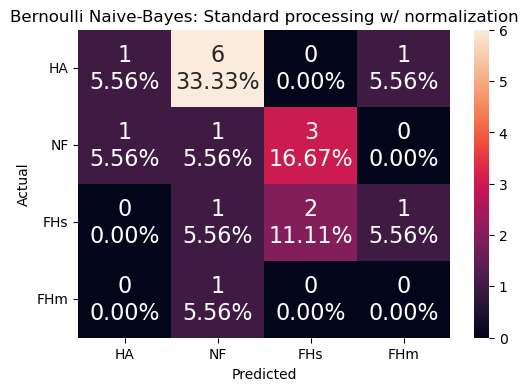

              precision    recall  f1-score   support

         FHm       0.00      0.00      0.00         1
         FHs       0.40      0.50      0.44         4
          HA       0.50      0.12      0.20         8
          NF       0.11      0.20      0.14         5

    accuracy                           0.22        18
   macro avg       0.25      0.21      0.20        18
weighted avg       0.34      0.22      0.23        18



In [13]:
classes = ['HA','NF','FHs','FHm']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Bernoulli Naive-Bayes: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))


### Remap Labels to Be Binary Single Fallers Included as Fallers

In [14]:
yTrainBinary = binaryLabelRemapping(yTrain_orig, True)
yTestBinary = binaryLabelRemapping(yTest_orig, True)

le2 = LabelEncoder()

yTrain_bin_orig = yTrainBinary
yTest_bin_orig = yTestBinary

yDf_bin = binaryLabelRemapping(yDf, True)

y_bin = np.asarray(le2.fit_transform(yDf_bin.label_binary.values))

#convert to numpy array
yTrainBinary = np.asarray(le2.fit_transform(yTrainBinary.label_binary.values))
yTestBinary = np.asarray(le2.fit_transform(yTestBinary.label_binary.values))

### Apply Lazy Classifier to Binary Data

In [15]:
lazyclass2 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
scores, predictions = lazyclass2.fit(xTrain, xTest, yTrainBinary, yTestBinary)
print(scores)
modelDict = lazyclass2.provide_models(xTrain, xTest, yTrainBinary, yTestBinary)

100%|██████████| 29/29 [00:00<00:00, 42.92it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
Perceptron                         0.83               0.82     0.82      0.84   
LinearSVC                          0.83               0.76     0.76      0.83   
RidgeClassifier                    0.83               0.76     0.76      0.83   
BernoulliNB                        0.72               0.75     0.75      0.74   
SGDClassifier                      0.78               0.72     0.72      0.78   
DecisionTreeClassifier             0.72               0.68     0.68      0.73   
LogisticRegression                 0.78               0.66     0.66      0.76   
NearestCentroid                    0.67               0.65     0.65      0.68   
GaussianNB                         0.50               0.59     0.59      0.51   
PassiveAggressiveClassifier        0.67               0.58     0.58      0.67   
LGBMClassifier              

In [16]:
#iterate through scores and find model with highest balanced accuracy
classifiers = scores.index.tolist()
balAccs = scores['ROC AUC']
bestModel = max(zip(classifiers, balAccs), key=lambda x: x[1])
pipe = modelDict[bestModel[0]]
print(bestModel)
#print pipeline steps
print(pipe.steps)

('Perceptron', 0.8230769230769232)
[('preprocessor', ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
           dtype='int64')),
                                ('categorical_low',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoding',
                             

In [97]:
#Perform grid search on best model
tuning_params = [{
    "classifier__penalty": ['elasticnet'],
    "classifier__l1_ratio": [0.48, 0.49, 0.5, 0.51, 0.52],
    "classifier__alpha": [1e-4, 1e-3, 1e-2, 0.09, 0.1, 0.11, 0.2],
    "classifier__tol": [5e-6],
    "classifier__eta0": [6e-5, 1e-4, 1e-3],
    "classifier__early_stopping": [False],
    "classifier__class_weight": [None],
    "classifier__warm_start": [True]
}]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, tuning_params, 
                    cv=skf.split(xTrain,yTrainBinary), scoring='roc_auc', 
                    n_jobs=-1, verbose=2, refit=True)

grid.fit(xTrain,yTrainBinary)

best_model = grid.best_estimator_
print(grid.best_score_)
print(grid.best_params_)

optimal_params = grid.best_params_

Fitting 5 folds for each of 105 candidates, totalling 525 fits
0.7298484848484847
{'classifier__alpha': 0.09, 'classifier__class_weight': None, 'classifier__early_stopping': False, 'classifier__eta0': 6e-05, 'classifier__l1_ratio': 0.48, 'classifier__penalty': 'elasticnet', 'classifier__tol': 5e-06, 'classifier__warm_start': True}


### Train Best Model with Optimal Parameters For Binary Labels Single Fallers are Fallers

In [98]:
clf = best_model

y_pred_bin = pipe.predict(xTest)

#map predictions back to original labels
y_pred_label = le2.inverse_transform(y_pred_bin)
y_test_label = le2.inverse_transform(yTestBinary)


### Create Confusion Matrix For Binary Labels

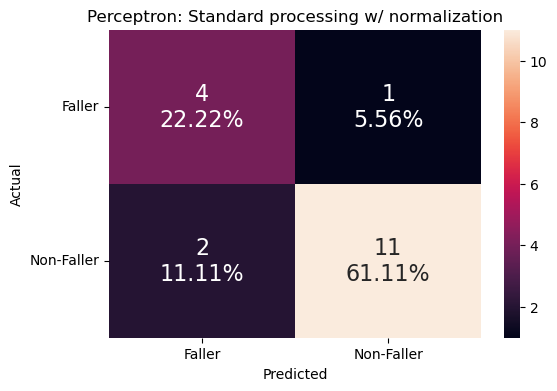

              precision    recall  f1-score   support

      Faller       0.67      0.80      0.73         5
  Non-Faller       0.92      0.85      0.88        13

    accuracy                           0.83        18
   macro avg       0.79      0.82      0.80        18
weighted avg       0.85      0.83      0.84        18



In [99]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Perceptron: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))

### Obtain Missclassifications

In [100]:
#create pandas dataframe with all misclassified samples
missclassifications = yTest_bin_orig.loc[yTest_bin_orig.label_binary!=y_pred_label]
print(missclassifications)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
70      68    NF   f    1.68   69.00 24.40                   0   
65      61    NF   m    1.73   65.30 21.80                   0   
86      87   FHs   f    1.60   77.10 30.10                   0   

   clinically_at_risk label_binary  
70                  0   Non-Faller  
65                  0   Non-Faller  
86                  1       Faller  


### Remap Labels to Be Binary Single Fallers Included as Non-Fallers

In [101]:
yTrainBinary = binaryLabelRemapping(yTrain_orig, False)
yTestBinary = binaryLabelRemapping(yTest_orig, False)

le3 = LabelEncoder()

yTrain_bin_orig = yTrainBinary
yTest_bin_orig = yTestBinary

yDf_bin = binaryLabelRemapping(yDf, False)

y_bin = np.asarray(le3.fit_transform(yDf_bin.label_binary.values))

#convert to numpy array
yTrainBinary = np.asarray(le3.fit_transform(yTrainBinary.label_binary.values))
yTestBinary = np.asarray(le3.fit_transform(yTestBinary.label_binary.values))

### Apply Lazy Classifier

In [102]:
lazyclass3 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
scores, predictions = lazyclass3.fit(xTrain, xTest, yTrainBinary, yTestBinary)
print(scores)
modelDict = lazyclass3.provide_models(xTrain, xTest, yTrainBinary, yTestBinary)

100%|██████████| 29/29 [00:00<00:00, 45.89it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.83               0.91     0.91      0.88   
CalibratedClassifierCV             0.94               0.50     0.50      0.92   
XGBClassifier                      0.94               0.50     0.50      0.92   
DummyClassifier                    0.94               0.50     0.50      0.92   
ExtraTreeClassifier                0.94               0.50     0.50      0.92   
ExtraTreesClassifier               0.94               0.50     0.50      0.92   
SVC                                0.94               0.50     0.50      0.92   
KNeighborsClassifier               0.94               0.50     0.50      0.92   
RidgeClassifierCV                  0.94               0.50     0.50      0.92   
RandomForestClassifier             0.94               0.50     0.50      0.92   
QuadraticDiscriminantAnalysi

In [103]:
#iterate through scores and find model with highest balanced accuracy
classifiers = scores.index.tolist()
balAccs = scores['ROC AUC']
bestModel = max(zip(classifiers, balAccs), key=lambda x: x[1])
pipe = modelDict[bestModel[0]]
print(bestModel)

('BernoulliNB', 0.9117647058823529)


### Train Best Model with Optimal Parameters For Binary Labels Single Fallers are Non-Fallers

In [104]:
#Perform grid search on best model
#find distribution of data for class prior
classPrior = np.bincount(y_bin) / len(y_bin)
#convert to list
classPrior = classPrior.tolist()

tuning_params = [{
    'classifier__alpha': [1e-7, 1e-5, 1e-3, 1e-1, 1e0],
    'classifier__binarize': [None, 0, 0.05, 0.1, 0.15, 0.2],
    'classifier__fit_prior': [True, False],
    'classifier__class_prior': [None, [0.5, 0.5], classPrior]
}]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, tuning_params, 
                    cv=skf.split(xTrain,yTrainBinary), scoring='roc_auc', 
                    n_jobs=-1, verbose=2, refit=True)

grid.fit(xTrain,yTrainBinary)

best_model = grid.best_estimator_
print(grid.best_score_)
print(grid.best_params_)

optimal_params = grid.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
0.7846153846153847
{'classifier__alpha': 0.1, 'classifier__binarize': 0.1, 'classifier__class_prior': None, 'classifier__fit_prior': True}


### Train Model with Optimal Parameters For Binary Labels Single Fallers are Non-Fallers

In [105]:
clf = best_model

y_pred_bin = pipe.predict(xTest)

#map predictions back to original labels
y_pred_label = le3.inverse_transform(y_pred_bin)
y_test_label = le3.inverse_transform(yTestBinary)

### Create Confusion Matrix For Binary Labels FHs -> Non-Fallers

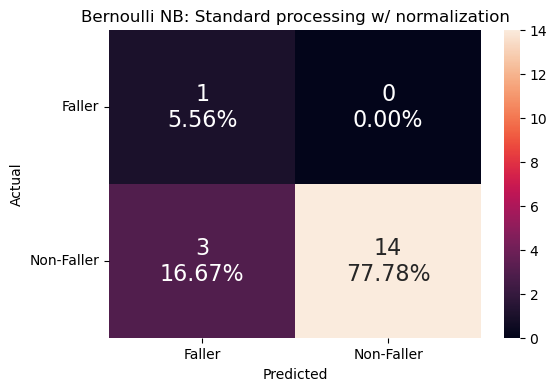

              precision    recall  f1-score   support

      Faller       0.25      1.00      0.40         1
  Non-Faller       1.00      0.82      0.90        17

    accuracy                           0.83        18
   macro avg       0.62      0.91      0.65        18
weighted avg       0.96      0.83      0.88        18



In [106]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Bernoulli NB: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))


### Obtain Missclassifications

In [107]:
#create pandas dataframe with all misclassified samples
missclassifications = yTest_bin_orig.loc[yTest_bin_orig.label_binary!=y_pred_label]
print(missclassifications)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
55      48    NF   m    1.70   73.40 25.40                   0   
10      19    HA   m    1.78   79.00 24.90                   1   
86      87   FHs   f    1.60   77.10 30.10                   0   

   clinically_at_risk label_binary  
55                  0   Non-Faller  
10                  0   Non-Faller  
86                  1   Non-Faller  
